In [14]:
import pandas as pd
import numpy as np

In [15]:
import pandas as pd

path = r"C:\Users\LENOVO\OneDrive\Pictures\Documents\GitHub\CBL-SIAB\data\BBCA.JK_extended.csv"
df = pd.read_csv(path)

df.head()


,Date,Open,High,Low,Close,Volume
0,2014-12-08 00:00:00+00:00,2655.0,2680.0,2645.0,2655.0,37435500
1,2014-12-09 00:00:00+00:00,2660.0,2680.0,2630.0,2650.0,38254000
2,2014-12-10 00:00:00+00:00,2630.0,2675.0,2630.0,2660.0,32998000
3,2014-12-11 00:00:00+00:00,2660.0,2675.0,2645.0,2655.0,54459500
4,2014-12-12 00:00:00+00:00,2640.0,2665.0,2640.0,2650.0,50302000


In [16]:
import pandas as pd
import numpy as np

# pilih kolom yang dipakai
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

In [17]:
df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.tz_localize(None)


In [18]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [19]:
df.duplicated().sum()

0

In [20]:
df.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
dtype: object

In [21]:
threshold = 0.003  # 0.3%

df['Return'] = (df['Close'].shift(-1) - df['Close']) / df['Close']

df['Label'] = np.where(df['Return'] > threshold, 1, 0)
df = df[:-1]


In [22]:
label_dist = df['Label'].value_counts().rename(index={1:'Naik', 0:'Turun'})
label_percent = (df['Label'].value_counts(normalize=True) * 100).rename(index={1:'Naik', 0:'Turun'})

pd.DataFrame({
    'Jumlah Data': label_dist,
    'Persentase (%)': label_percent.round(2)
})

,Jumlah Data,Persentase (%)
Label,,
Turun,1714,62.88
Naik,1012,37.12


In [23]:
# Moving Average 5 hari
df['MA5'] = df['Close'].rolling(window=5).mean()

# Moving Average 10 hari
df['MA10'] = df['Close'].rolling(window=10).mean()


In [24]:
df = df.dropna().reset_index(drop=True)

In [25]:
df.head()

,Date,Open,High,Low,Close,Volume,Return,Label,MA5,MA10
0,2014-12-19,2630.0,2650.0,2620.0,2635.0,83389500,-0.007590,0,2596.0,2625.0
1,2014-12-22,2650.0,2650.0,2615.0,2615.0,33301000,0.005736,1,2597.0,2621.0
2,2014-12-23,2640.0,2640.0,2625.0,2630.0,21132000,0.003802,1,2609.0,2619.0
3,2014-12-24,2650.0,2655.0,2635.0,2640.0,19135500,-0.003788,0,2623.0,2617.0
4,2014-12-29,2630.0,2650.0,2625.0,2630.0,24315000,-0.001901,0,2630.0,2614.5


In [26]:
X = df[
    [
        'Open',
        'High',
        'Low',
        'Close',
        'Volume',
        'MA5',
        'MA10',
        'Return',
    ]
]

y = df['Label']


In [27]:
split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]

In [28]:
print("Total data :", len(df))
print("Train data :", len(X_train))
print("Test data  :", len(X_test))


Total data : 2717
Train data : 2173
Test data  : 544


In [29]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

=== HASIL DATA TRAIN ===
Akurasi (Train): 1.0
Confusion Matrix (Train):
 [[1357    0]
 [   0  816]]
              precision    recall  f1-score   support

       Turun       1.00      1.00      1.00      1357
        Naik       1.00      1.00      1.00       816

    accuracy                           1.00      2173
   macro avg       1.00      1.00      1.00      2173
weighted avg       1.00      1.00      1.00      2173



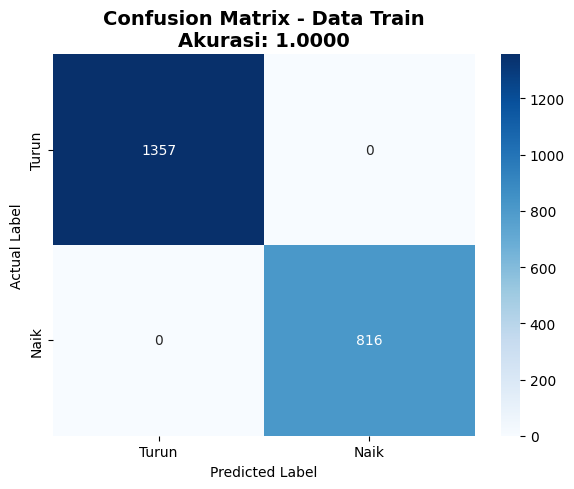

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Prediksi data train
y_train_pred = model.predict(X_train)

# Hitung akurasi
train_accuracy = accuracy_score(y_train, y_train_pred)

print("=== HASIL DATA TRAIN ===")
print("Akurasi (Train):", train_accuracy)
print("Confusion Matrix (Train):\n", confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred, target_names=['Turun','Naik']))

# Confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred)

# Visualisasi
plt.figure(figsize=(6,5))
sns.heatmap(
    cm_train,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Turun', 'Naik'],
    yticklabels=['Turun', 'Naik']
)

plt.title(f'Confusion Matrix - Data Train\nAkurasi: {train_accuracy:.4f}',
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.tight_layout()
plt.show()


=== HASIL DATA TEST ===
Akurasi (Test): 1.0
Confusion Matrix (Test):
 [[351   0]
 [  0 193]]
              precision    recall  f1-score   support

       Turun       1.00      1.00      1.00       351
        Naik       1.00      1.00      1.00       193

    accuracy                           1.00       544
   macro avg       1.00      1.00      1.00       544
weighted avg       1.00      1.00      1.00       544



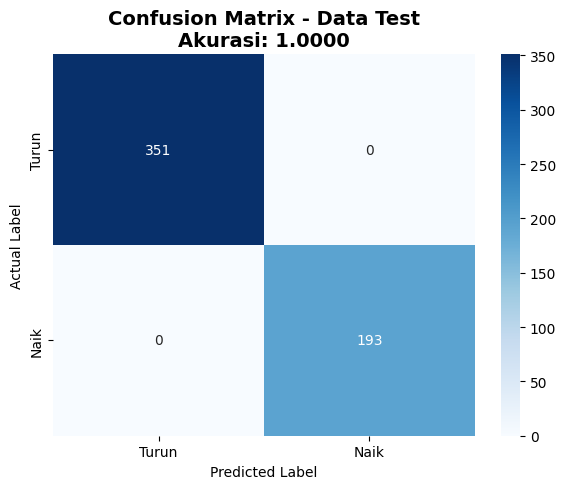

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Prediksi data test
y_test_pred = model.predict(X_test)

# Hitung akurasi
test_accuracy = accuracy_score(y_test, y_test_pred)

print("=== HASIL DATA TEST ===")
print("Akurasi (Test):", test_accuracy)
print("Confusion Matrix (Test):\n", confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, target_names=['Turun','Naik']))

# Confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)

# Visualisasi
plt.figure(figsize=(6,5))
sns.heatmap(
    cm_test,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Turun', 'Naik'],
    yticklabels=['Turun', 'Naik']
)

plt.title(f'Confusion Matrix - Data Test\nAkurasi: {test_accuracy:.4f}',
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.tight_layout()
plt.show()
